# 02 - Randomized Experiments and Stats Review


## An A/B Testing Example

In [1]:
import pandas as pd
import numpy as np

np.random.seed(123)
data = (
    pd.read_csv("./data/online_classroom.csv")
    .assign(cross_sell_email = lambda d: np.select(
        [d["format_ol"].astype(bool), d["format_blended"].astype(bool)],
        ["no_email", "long"],
        default="short")
           )
    .assign(age = lambda d: np.random.gamma(1.5, 5, d.shape[0]).astype(int)+14)
    .assign(conversion = lambda d: ((d["falsexam"]-d["age"]) > 70).astype(int))
    .drop(columns=["asian", "black", "hawaiian", "hispanic", "unknown", "white", "format_ol", "format_blended", "falsexam"])
)

print(data.shape)
data.head()

(323, 4)


,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0


In [2]:
(data
 .groupby(["cross_sell_email"])
 .mean())

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


 
## The Most Dangerous Equation
 


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


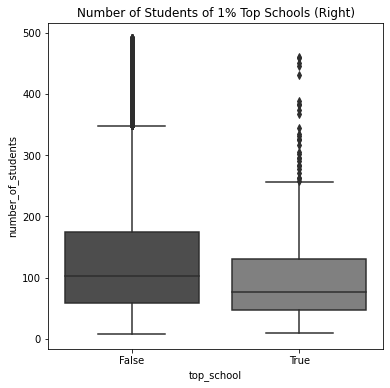

In [5]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

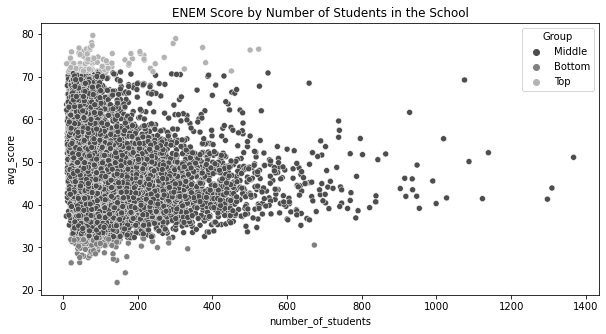

In [6]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data, hue="Group")

plt.title("ENEM Score by Number of Students in the School");

##  The Standard Error of Our Estimates


In [7]:
short_email = data.query("cross_sell_email=='short'")["conversion"]
long_email = data.query("cross_sell_email=='long'")["conversion"]
email = data.query("cross_sell_email!='no_email'")["conversion"]
no_email = data.query("cross_sell_email=='no_email'")["conversion"]

data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

In [8]:
def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Long Email:", se(long_email))
print("SE for Short Email:", se(short_email))

SE for Long Email: 0.021946024609185506
SE for Short Email: 0.030316953129541618


In [9]:
print("SE for Long Email:", long_email.sem())
print("SE for Short Email:", short_email.sem())

SE for Long Email: 0.021946024609185506
SE for Short Email: 0.030316953129541618


## Confidence Intervals

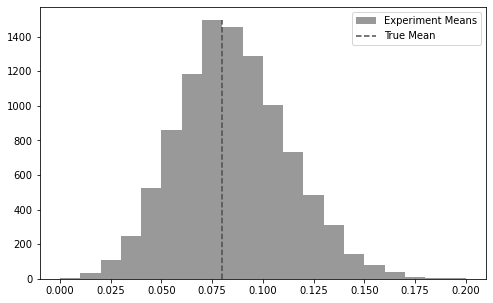

In [10]:
n = 100
conv_rate = 0.08

def run_experiment(): 
    return np.random.binomial(1, conv_rate, size=n)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=20, label="Experiment Means", color="0.6")
plt.vlines(conv_rate, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="0.3")
plt.legend();

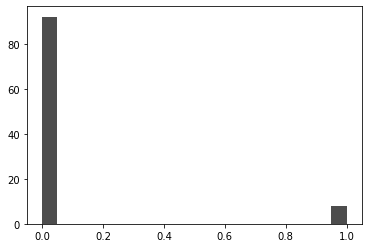

In [11]:
np.random.seed(42)
plt.hist(np.random.binomial(1, 0.08, 100), bins=20);

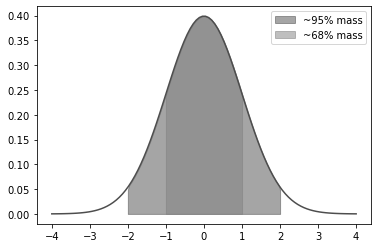

In [12]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, linestyle="solid")
plt.fill_between(x.clip(-2, +2), 0, y, alpha=0.5, label="~95% mass", color="C0")
plt.fill_between(x.clip(-1, +1), 0, y, alpha=0.5, label="~68% mass", color="C1")
plt.legend()
plt.show()

In [13]:
exp_se = short_email.sem()
exp_mu = short_email.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print("95% CI for Short Email: ", ci)

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)


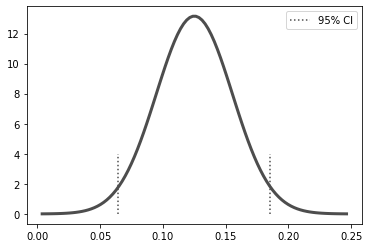

In [14]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.legend()
plt.show()

In [15]:
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

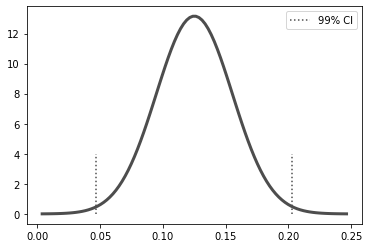

In [16]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="99% CI")
plt.legend()
plt.show()

In [17]:
def ci(y: pd.Series):
    return (y.mean() - 2 * y.sem(), y.mean() + 2 * y.sem())

print("95% CI for Short Email:", ci(short_email))
print("95% CI for Long Email:", ci(long_email))
print("95% CI for No Email:", ci(no_email))

95% CI for Short Email: (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email: (0.01115382234126202, 0.09893792077800403)
95% CI for No Email: (0.0006919679286838468, 0.08441441505003955)


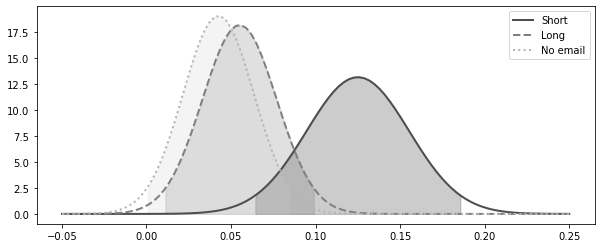

In [18]:
plt.figure(figsize=(10,4))

x = np.linspace(-0.05, .25, 100)
short_dist = stats.norm.pdf(x, short_email.mean(), short_email.sem())
plt.plot(x, short_dist, lw=2, label="Short", linestyle=linestyle[0])
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), 0, short_dist, alpha=0.2, color="0.0")

long_dist = stats.norm.pdf(x, long_email.mean(), long_email.sem())
plt.plot(x, long_dist, lw=2, label="Long", linestyle=linestyle[1])
plt.fill_between(x.clip(ci(long_email)[0], ci(long_email)[1]), 0, long_dist, alpha=0.2, color="0.4")

no_email_dist = stats.norm.pdf(x, no_email.mean(), no_email.sem())
plt.plot(x, no_email_dist, lw=2, label="No email", linestyle=linestyle[2])
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 0, no_email_dist, alpha=0.2, color="0.8")

plt.legend()
plt.show()

## Hypothesis Testing
 


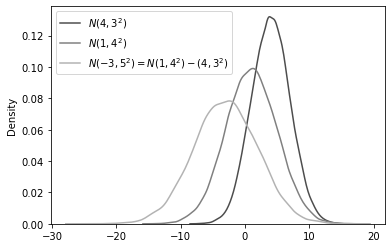

In [19]:
np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1

sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(-3, 5^2) = N(1,4^2) - (4,3^2)$")
plt.legend()
plt.show()

In [20]:
diff_mu = short_email.mean() - no_email.mean()
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print("95% CI for the different (short email - no email): ", ci)

95% CI for the different (short email - no email):  (0.01023980847439844, 0.15465380854687816)


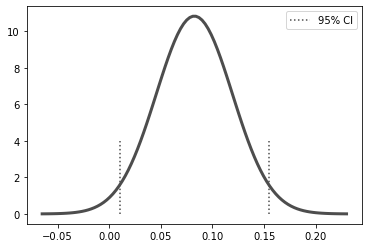

In [21]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.legend()
plt.show()

### Null Hypothesis


In [22]:
diff_mu_shifted =  short_email.mean() - no_email.mean() - 0.01 # shifting the CI
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu_shifted - 1.96*diff_se, diff_mu_shifted + 1.96*diff_se)
print("95% CI 1% difference between (short email - no email): ", ci)

95% CI 1% difference between (short email - no email):  (0.00023980847439844521, 0.14465380854687815)



### Test Statistic
 

In [23]:
t_stat = (diff_mu - 0) / diff_se
t_stat

2.2379512318715364

 
## P-values


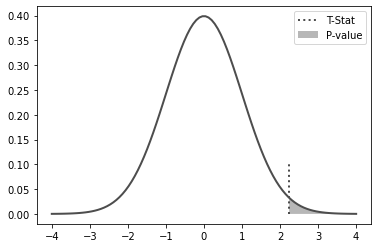

In [24]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, lw=2)
plt.vlines(t_stat, ymin=0, ymax=0.1, ls="dotted", label="T-Stat", lw=2)
plt.fill_between(x.clip(t_stat), 0, y, alpha=0.4, label="P-value")
plt.legend()
plt.show()

In [25]:
print("P-value:", (1 - stats.norm.cdf(t_stat))*2)

P-value: 0.025224235562152142


## Power
 

In [26]:
stats.norm.cdf(0.84)

0.7995458067395503

### Sample Size Calculation
 


In [27]:
np.ceil(16 * no_email.std()**2/0.01)

66.0

In [28]:
data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64